In [1]:
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
import numpy as np
import scipy as sp
from scipy import stats
import time
from scipy.stats import pearsonr
plt.style.use('tableau-colorblind10')


def eval_lats(pred, target, res=1000):
    errs = np.zeros((2, res))
    for i in range(2):
        for i_s, s in enumerate(np.linspace(0, 2 * np.pi, res)):
            newpred = 2 * (0.5 - i) * pred + s
            errs[i, i_s] = np.mean(np.arccos(np.cos(newpred - target)))
            
    i, s = np.unravel_index(errs.argmin(), errs.shape)
            
    return np.amin(errs), 2 * (0.5 - i), np.linspace(0, 2 * np.pi, res)[s]

In [2]:
def return_plot_list(
    scale_num_list,
    scaling_type, #{'N', 'T'}
    model_type, #{'VAE', 'GP', 'mGP'}
    feature_type, #{'bump', 'shared', 'separate', 'orig', 'cosyne'}
    vae_inference, #{'inf_False_', 'inf_True_', ''}
    rate_or_latents, #{'latents', 'rates'}
    n_sims=20
):  
    mean_list = []
    var_list = []
    
    if model_type == 'mGP':
        if scaling_type == 'N':
            num_train = 1000
        elif scaling_type == 'T':
            num_neuron_train = 30
        for scale_num in scale_num_list:
            if scaling_type == 'N':
                num_neuron_train = scale_num
            elif scaling_type == 'T':
                num_train = scale_num
            rep_list = []
            for rep_num in range(n_sims):
                file_name = os.path.join(os.getcwd(), 'results', 'mgplvm_results', 'mgplvm_res_%s_%d_N%d_T%d.p' % (
                    feature_type, rep_num, num_neuron_train, num_train))
                
                with open(file_name, 'rb') as handle:
                    stats_ = pickle.load(handle)
                
                dgf = n_sims - 1
                
                if rate_or_latents == 'rates':
                    corr_rates = []
                    for j in np.where(~stats_['neuron_train_ind'])[0]:
                        corr_rates.append(pearsonr(stats_['y_test'][j, :], stats_['y_pred'][j, -stats_['y_test'].shape[1]:])[0])

                    corr_rates = np.nanmean(corr_rates)
                    rep_list.append(corr_rates)
                
                if rate_or_latents == 'LLH':
                    temp = []
                    for j in np.where(~stats_['neuron_train_ind'])[0]:
                        print(stats_['y_pred'][j, -stats_['y_test'].shape[1]:])
                        temp.append(np.sum(stats_['y_pred'][j, -stats_['y_test'].shape[1]:] - stats_['y_test'][j, :] * np.log(stats_['y_pred'][j, -stats_['y_test'].shape[1]:] + 1e-9)))
                    
                    rep_list.append(np.sum(temp))

                
                if rate_or_latents == 'latents':
                    err, _, _ = eval_lats(stats_['z_pred'][-stats_['z_test'].shape[0]:], stats_['z_test'])
                    rep_list.append(err)
                
            mean_list.append(np.mean((rep_list)))
            var_list.append(np.sum(((rep_list) - np.mean((rep_list)))**2)/dgf)
                
    else:
        for scale_num in scale_num_list:
            file_name = os.path.join(os.getcwd(), 'results', 'fig2_stats_peakrate_0.5_%s_%s_%s%s_%d.pkl' % (
                model_type, feature_type, vae_inference, scaling_type, scale_num))

            with open(file_name, 'rb') as handle:
                stats_ = pickle.load(handle)

            dgf = n_sims - 1

            if rate_or_latents == 'rates':
                mean_list.append(np.mean((stats_['corr_rates'])))
                var_list.append(np.sum(((stats_['corr_rates']) - np.mean((stats_['corr_rates'])))**2)/dgf)

            if rate_or_latents == 'LLH':
                temp = []
                for rep_num in range(n_sims):
                    temp.append(np.sum(stats_['y_pred'][rep_num] - stats_['y_test'][rep_num] * np.log(stats_['y_pred'][rep_num] + 1e-9)))
                
                mean_list.append(np.mean((temp)))
                var_list.append(temp)
                
            if rate_or_latents == 'latents':
                temp = []
                for i in range(n_sims):
                    err, _, _ = eval_lats(stats_['z_pred'][i], stats_['z_test'][i])
                    temp.append(err)

                mean_list.append(np.mean((temp)))
                var_list.append(np.sum(((temp) - np.mean((temp)))**2)/dgf)

    return mean_list, var_list, dgf


In [3]:
def make_fig2A():
    
    T_list = [75, 100, 150, 200, 300, 400, 500, 750, 1000, 2500]
    N_list = [10, 15, 20, 25, 30, 35, 40, 45, 50]
        
    # All fae models (Table1)
    params1 = {
        #'mGP-g' : [N_list, 'N', 'mGP', 'orig', '', 'LLH'],
        'i-faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_True_', 'LLH'],
        'i-faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_True_', 'LLH'],
        'i-faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_True_', 'LLH'],
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_False_', 'LLH'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_False_', 'LLH'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_False_', 'LLH']
    }
    
    params2 = {
        'i-faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'i-faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'i-faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_True_', 'latents'],
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_False_', 'latents'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_False_', 'latents'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_False_', 'latents']
    }
    
    params3 = {
        #'mGP-g' : [T_list, 'T', 'mGP', 'orig', '', 'LLH'],
        'i-faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_True_', 'LLH'],
        'i-faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_True_', 'LLH'],
        'i-faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_True_', 'LLH'],
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_False_', 'LLH'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_False_', 'LLH'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_False_', 'LLH']
    }
    
    params4 = {
        'i-faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'i-faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'i-faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_True_', 'latents'],
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_False_', 'latents'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_False_', 'latents'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_False_', 'latents'],
    }
    
    
    
    # Only i-fae models + mGP comparison (Fig4)
    params1 = {
        #'mGP' : [N_list, 'N', 'mGP', 'orig', '', 'rates'],
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_True_', 'LLH'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_True_', 'LLH'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_True_', 'LLH'],
    }
    
    params2 = {
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_True_', 'latents'],
        'mGP' : [N_list, 'N', 'mGP', 'orig', '', 'latents'],
    }
    
    params3 = {
        #'mGP' : [T_list, 'T', 'mGP', 'orig', '', 'rates'],
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_True_', 'LLH'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_True_', 'LLH'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_True_', 'LLH'],
    }
    
    params4 = {
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_True_', 'latents'],
        'mGP' : [T_list, 'T', 'mGP', 'orig', '', 'latents'],
    }
    
    
    
    # Fig4 but without smoothing kernel in Conv1D (Appendix)
    params1 = {
        #'mGP' : [N_list, 'N', 'mGP', 'orig', '', 'rates'],
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_nosmooth', 'inf_True_', 'LLH'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_nosmooth', 'inf_True_', 'LLH'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump_nosmooth', 'inf_True_', 'LLH'],
    }
    
    params2 = {
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_nosmooth', 'inf_True_', 'latents'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_nosmooth', 'inf_True_', 'latents'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump_nosmooth', 'inf_True_', 'latents'],
        'mGP' : [N_list, 'N', 'mGP', 'orig', '', 'latents'],
    }
    
    params3 = {
        #'mGP' : [T_list, 'T', 'mGP', 'orig', '', 'rates'],
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_nosmooth', 'inf_True_', 'LLH'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_nosmooth', 'inf_True_', 'LLH'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump_nosmooth', 'inf_True_', 'LLH'],
    }
    
    params4 = {
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_nosmooth', 'inf_True_', 'latents'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_nosmooth', 'inf_True_', 'latents'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump_nosmooth', 'inf_True_', 'latents'],
        'mGP' : [T_list, 'T', 'mGP', 'orig', '', 'latents'],
    }
    
    
    
    fig1, ax1 = plt.subplots(1,1, figsize=(5,4))
    fig2, ax2 = plt.subplots(1,1, figsize=(5,4))
    fig3, ax3 = plt.subplots(1,1, figsize=(5,4))
    fig4, ax4 = plt.subplots(1,1, figsize=(5,4))
    
    fig5, ax5 = plt.subplots(1,1, figsize=(5,2))
    fig6, ax6 = plt.subplots(1,1, figsize=(5,2))
    fig7, ax7 = plt.subplots(1,1, figsize=(20,20))
    
    rank_list = np.zeros((len(params1.keys()), len(N_list), 20))
    cnt = 0
    for key, val in params1.items():
        means, varis, dgf = return_plot_list(*val)
        if val[-1] == 'LLH':
            ax1.plot(val[0], means, '.-', linewidth=2)
            rank_list[cnt, :, :] = np.array(varis)
            cnt += 1
        else:
            ax1.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                         fmt=".-", capsize=2, linewidth=2)
        ax1.ticklabel_format(axis='y', style='scientific', scilimits=(0,0))
        ax1.set_xlabel(r'$N_{train}$', fontsize=20)
        if val[-1] == 'LLH':
            ax1.set_ylabel('Rate pred. [NLLH]', fontsize=20)
        else:
            ax1.set_ylabel('Rate pred. [corr.]', fontsize=20)
        ax1.spines['right'].set_visible(False)
        ax1.spines['top'].set_visible(False)
        ax1.tick_params(axis='x', labelsize=15)
        ax1.tick_params(axis='y', labelsize=15)

        #print(key, means[1], means[4], means[7])
    
    if val[-1] == 'LLH':
        def rank(x, axis):
            return np.argsort(np.argsort(x, axis=axis), axis=axis) + 1
        #print(rank(rank_list, 0))
        ranked_list = (np.mean(rank(rank_list, 0), axis=-1))
        for i in range(ranked_list.shape[0]):
            ax5.plot(val[0], ranked_list[i], '.-', linewidth=2)
        ax5.set_yticks([1,2,3], [1,2,3], fontsize=15)
        ax5.set_xlabel(r'$N_{train}$', fontsize=20)
        ax5.set_ylabel('Avg. rank', fontsize=20)
        ax5.tick_params(axis='x', labelsize=15)
    
    print("First done")
    labels = []
    for key, val in params2.items():
        means, varis, dgf = return_plot_list(*val)
        ax3.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                     fmt=".-", capsize=2, linewidth=2)
        ax3.set_xlabel(r'$N_{train}$', fontsize=20)
        ax3.set_ylabel("Latent pred. [GE]", fontsize=20)
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.tick_params(axis='x', labelsize=15)
        ax3.tick_params(axis='y', labelsize=15)
        labels.append(key)
        #print(key, means[1], means[4], means[7])
        
    print("Second done")
    
    rank_list = np.zeros((len(params1.keys()), len(T_list), 20))
    cnt = 0
    for key, val in params3.items():
        means, varis, dgf = return_plot_list(*val)
        if val[-1] == 'LLH':
            ax2.plot(val[0], means, '.-', linewidth=2)
            rank_list[cnt, :, :] = np.array(varis)
            cnt += 1
        else:
            ax2.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                        fmt=".-", capsize=2, linewidth=2)
        ax2.ticklabel_format(axis="y", style="scientific", scilimits=(0,0))
        ax2.set_xscale('log', base=2)
        ax2.set_xticks([2**7, 2**8, 2**9, 2**10, 2**11])
        ax2.set_xlabel(r'$T_{train}$', fontsize=20)
        ax2.set_ylabel("Rate pred.", fontsize=20)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.tick_params(axis='x', labelsize=15)
        ax2.tick_params(axis='y', labelsize=15)
    
        #print(key, means[1], means[6], means[8])
        
    if val[-1] == 'LLH':        
        def rank(x, axis):
            return np.argsort(np.argsort(x, axis=axis), axis=axis) + 1
        #print(rank(rank_list, 0))
        ranked_list = (np.mean(rank(rank_list, 0), axis=-1))
        for i in range(ranked_list.shape[0]):
            ax6.plot(val[0], ranked_list[i], '.-', linewidth=2)
        ax6.set_xscale('log', base=2)
        ax6.set_xticks([2**7, 2**8, 2**9, 2**10, 2**11])
        ax6.set_yticks([1,2,3], [1,2,3], fontsize=15)
        ax6.set_xlabel(r'$T_{train}$', fontsize=20)
        ax6.set_ylabel('Avg. rank', fontsize=20)
        ax6.tick_params(axis='x', labelsize=15)
         
    print("Third done")
        
    for key, val in params4.items():
        means, varis, dgf = return_plot_list(*val)
        ax4.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                    fmt=".-", capsize=2, linewidth=2)
        ax4.set_xscale('log', base=2)
        ax2.set_xticks([2**7, 2**8, 2**9, 2**10, 2**11])
        ax4.set_xlabel(r'$T_{train}$', fontsize=20)
        ax4.set_ylabel("Latent pred.", fontsize=20)
        ax4.spines['right'].set_visible(False)
        ax4.spines['top'].set_visible(False)
        ax4.tick_params(axis='x', labelsize=15)
        ax4.tick_params(axis='y', labelsize=15)
        
        #print(key, means[1], means[6], means[8])
    
    print("Fourth done")
    
    fig1.tight_layout()
    fig2.tight_layout()
    fig3.tight_layout()
    fig4.tight_layout()
    fig5.tight_layout()
    fig6.tight_layout()
    
    #fig1.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_1_ns" + ".pdf")
    #fig2.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_2_ns" + ".pdf")
    #fig3.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_3_ns" + ".pdf")
    #fig4.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_4_ns" + ".pdf")
    #fig5.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_5_ns" + ".pdf")
    #fig6.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_6_ns" + ".pdf")
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # alpha=0.3 diffuse, alpha=1 solid
    patches = [mpatches.Patch(color=colors[i], label=labels[i], alpha=1) for i in range(len(params2.keys()))]
    ax7.legend(handles=patches, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.5), edgecolor='black',
               fancybox=True, shadow=False, ncol=len(params2.keys()), fontsize=15)
    fig7.tight_layout()
    #fig7.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig2a_legend" + ".pdf")    
        

In [4]:
def vae_check():    
    N_list = [10, 15, 20, 25, 30, 35, 40, 45, 50]
    T_list = [75, 100, 150, 200, 300, 400, 500, 750, 1000, 2500]
        
    # MLP VAE as well
    params1 = {
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_False_', 'LLH'],
        'mlpVAE' : [N_list, 'N', 'VAE', 'shared_mlp', 'inf_False_', 'LLH']
    }
    params3 = {
        'faeLVM-n' : [T_list, 'T', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'faeLVM-s' : [T_list, 'T', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'faeLVM-b' : [T_list, 'T', 'VAE', 'bump', 'inf_True_', 'latents'],
        'mGP' : [T_list, 'T', 'mGP', 'orig', '', 'latents'],
        'VAE' : [T_list, 'T', 'VAE', 'separate_mlp', 'inf_False_', 'latents'],
    }
    params2 = {
        'faeLVM-n' : [N_list, 'N', 'VAE', 'separate_flex64', 'inf_True_', 'latents'],
        'faeLVM-s' : [N_list, 'N', 'VAE', 'shared_flex', 'inf_True_', 'latents'],
        'faeLVM-b' : [N_list, 'N', 'VAE', 'bump', 'inf_True_', 'latents'],
        'mGP' : [N_list, 'N', 'mGP', 'orig', '', 'latents'],
        'VAE' : [N_list, 'N', 'VAE', 'separate_mlp', 'inf_False_', 'latents'],
    }
     
    labels=[]
    fig2, ax2 = plt.subplots(1,1, figsize=(5,4))
    fig3, ax3 = plt.subplots(1,1, figsize=(5,4))
    fig7, ax7 = plt.subplots(1,1, figsize=(20,20))
    for key, val in params2.items():
        means, varis, dgf = return_plot_list(*val)
        ax2.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                     fmt=".-", capsize=2, linewidth=2)
        ax2.set_xlabel(r'$N_{train}$', fontsize=20)
        ax2.set_ylabel("Latent pred. [GE]", fontsize=20)
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.tick_params(axis='x', labelsize=15)
        ax2.tick_params(axis='y', labelsize=15)
        #labels.append(key)
        
    for key, val in params3.items():
        means, varis, dgf = return_plot_list(*val)
        ax3.errorbar(x=val[0], y=means, yerr=((np.sqrt(varis))/np.sqrt(dgf + 1)),
                    fmt=".-", capsize=2, linewidth=2)
        ax3.set_xscale('log', base=2)
        ax3.set_xticks([2**7, 2**8, 2**9, 2**10, 2**11])
        ax3.set_xlabel(r'$T_{train}$', fontsize=20)
        ax3.set_ylabel("Latent pred.", fontsize=20)
        ax3.spines['right'].set_visible(False)
        ax3.spines['top'].set_visible(False)
        ax3.tick_params(axis='x', labelsize=15)
        ax3.tick_params(axis='y', labelsize=15)
        labels.append(key)    
    
    fig2.tight_layout()
    fig3.tight_layout()
    
    #fig2.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig3_1reb" + ".pdf")
    #fig3.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig3_2reb" + ".pdf")
    
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    # alpha=0.3 diffuse, alpha=1 solid
    patches = [mpatches.Patch(color=colors[i], label=labels[i], alpha=1) for i in range(len(params3.keys()))]
    ax7.legend(handles=patches, labels=labels, loc='upper center', bbox_to_anchor=(0.5, -0.5), edgecolor='black',
               fancybox=True, shadow=False, ncol=len(params3.keys()), fontsize=15)
    fig7.tight_layout()
    #fig7.savefig(time.strftime("./plots/%Y-%m-%d-") + "Fig3_3reb" + ".pdf")  

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kdais\\prog\\4222_understanding_neural_coding_on-Supplementary Material\\ICLR\\results\\fig2_stats_peakrate_0.5_VAE_separate_flex64_inf_True_N_10.pkl'

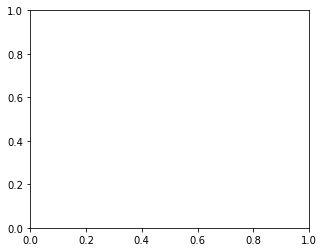

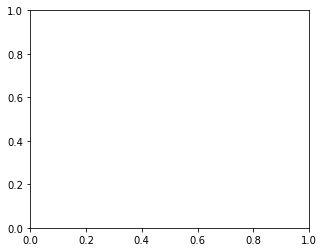

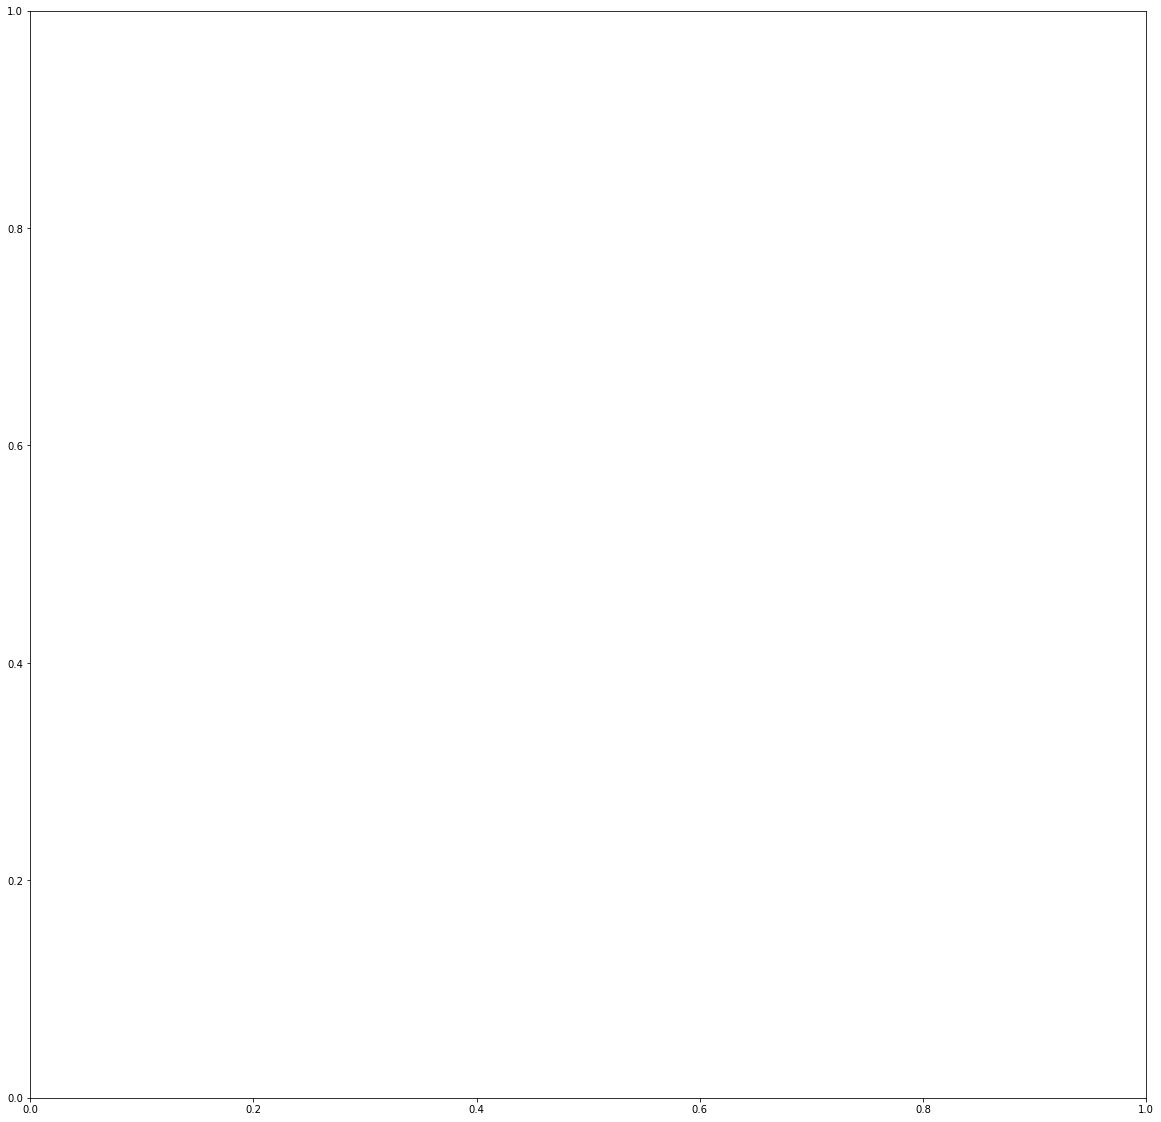

In [5]:
vae_check()

In [ ]:
make_fig2A()